https://www.datacamp.com/tutorial/introduction-hierarchical-clustering-python

O conjunto de dados tem 9.500 empréstimos com informações sobre a estrutura do empréstimo, o mutuário e se o empréstimo foi pago integralmente. Vamos nos livrar da coluna de destino not.fully.paid para atender ao aspecto não supervisionado.




In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("itssuru/loan-data")

# print("Path to dataset files:", path)

/home/kelvin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 213k/213k [00:00<00:00, 870kB/s]

Extracting files...
Path to dataset files: /home/kelvin/.cache/kagglehub/datasets/itssuru/loan-data/versions/1


In [3]:
import pandas as pd
loan_data = pd.read_csv("loan_data.csv")
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Lidando com valores ausentes

In [6]:
percent_missing = round(100*loan_data.isnull().sum() / len(loan_data), 2)
percent_missing

credit.policy        0.0
purpose              0.0
int.rate             0.0
installment          0.0
log.annual.inc       0.0
dti                  0.0
fico                 0.0
days.with.cr.line    0.0
revol.bal            0.0
revol.util           0.0
inq.last.6mths       0.0
delinq.2yrs          0.0
pub.rec              0.0
not.fully.paid       0.0
dtype: float64

Sem valores ausentes :D

### Eliminando colunas indesejadas

Vamos analisar os dados do empréstimo usando todas as colunas, exceto a de Purpose (Propósito) e Not.fully.paid (Não totalmente pago).

In [8]:
cleaned_data = loan_data.drop(["purpose", "not.fully.paid"], axis=1)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   int.rate           9578 non-null   float64
 2   installment        9578 non-null   float64
 3   log.annual.inc     9578 non-null   float64
 4   dti                9578 non-null   float64
 5   fico               9578 non-null   int64  
 6   days.with.cr.line  9578 non-null   float64
 7   revol.bal          9578 non-null   int64  
 8   revol.util         9578 non-null   float64
 9   inq.last.6mths     9578 non-null   int64  
 10  delinq.2yrs        9578 non-null   int64  
 11  pub.rec            9578 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 898.1 KB


### Análise de outliers

Uma das fraquezas do clustering hierárquico é que ele é sensível a outliers. A distribuição de cada variável é dada pelo boxplot. 

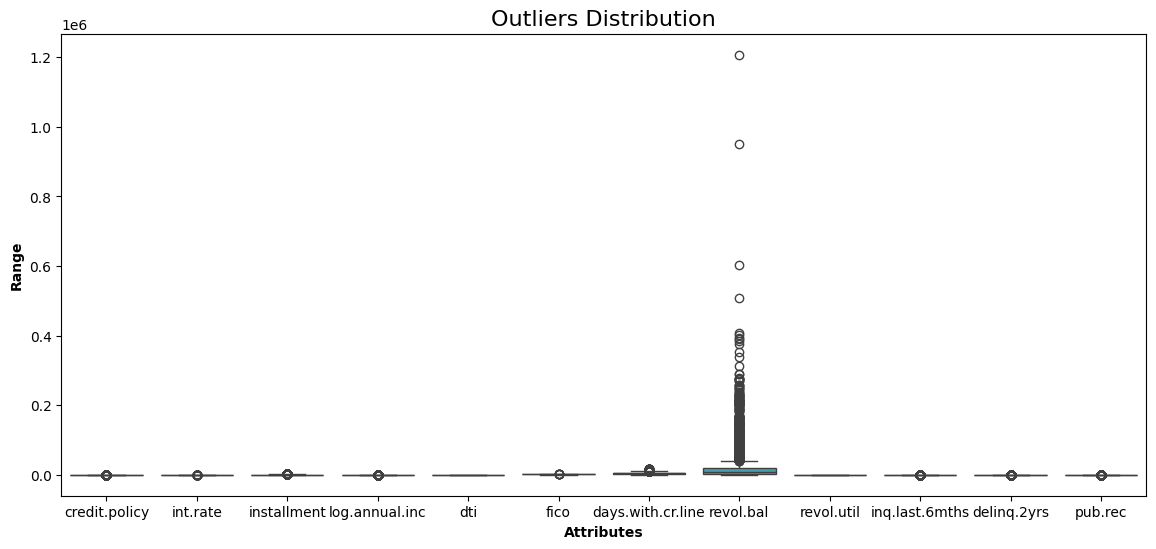

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
def show_boxplot(df):
    plt.rcParams["figure.figsize"] = [14, 6]
    sns.boxplot(data = df, orient="v")
    plt.title("Outliers Distribution", fontsize=16)
    plt.ylabel("Range", fontweight="bold")
    plt.xlabel("Attributes", fontweight="bold")

show_boxplot(cleaned_data)

O saldo rotativo do mutuário (revol_bal) é o único atributo com pontos de dados distantes dos demais. 

Ao usar a abordagem do intervalo interquartil, podemos remover todos os pontos que estão fora do intervalo definido pelos quartis +/-1,5 * IQR, onde IQR é o intervalo interquartil. 

Isso é obtido com a seguinte função auxiliar. 

In [ ]:
def remove_outliers(data):
    df = data.copy()
    for col in list(df.columns):
        Q1 = df[str(col)].quantile(0.05)
        Q3 = df[str(col)].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[str(col)] >= lower_bound) & (df[str(col)] <= upper_bound)] 

    return df

In [15]:
data_without_outliers = remove_outliers(cleaned_data)

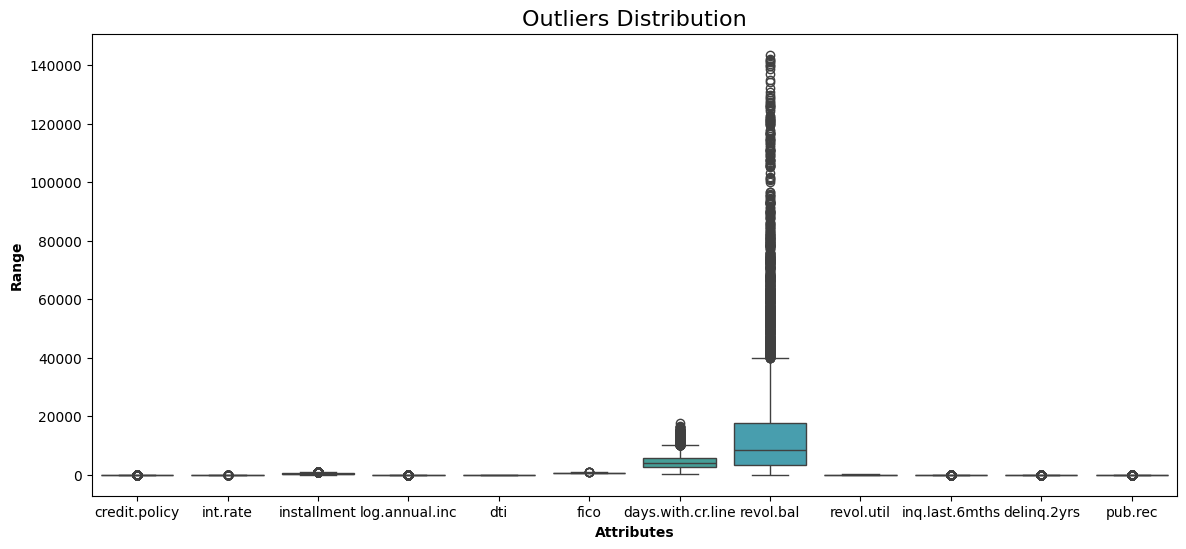

In [16]:
show_boxplot(data_without_outliers)

Não há mais pontos de dados fora do intervalo interquartil.




In [17]:
data_without_outliers.shape



(9319, 12)

Ou seja, 9319 linhas e 12 colunas

### Redimensionando os dados

Pois a clusterização hierarquica utiliza a distância euclideana!

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_without_outliers)
scaled_data.shape

(9319, 12)

## Finalmente, aplicando o algoritmo hierárquico!

Vamos ver todos os três métodos de ligação (Ver imagem no link do tutorial).

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
complete_clustering = linkage(scaled_data, method="complete", metric="euclidean")
average_clustering = linkage(scaled_data, method="average", metric="euclidean")
single_clustering = linkage(scaled_data, method="single", metric="euclidean")

Depois de calcularmos todos os três agrupamentos, os dendrogramas correspondentes são mostrados a seguir, começando com o agrupamento completo  


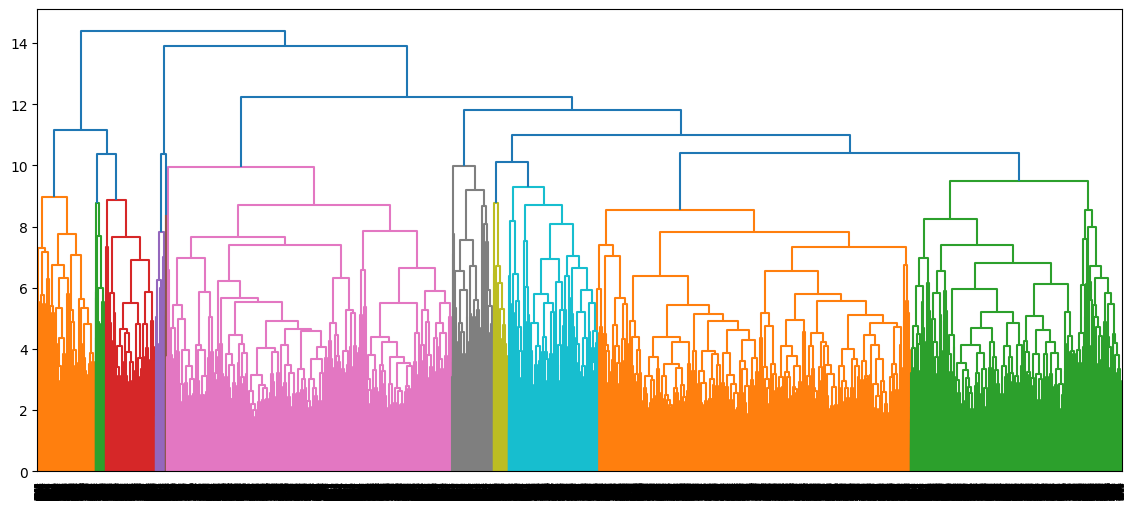

In [21]:
dendrogram(complete_clustering)
plt.show()

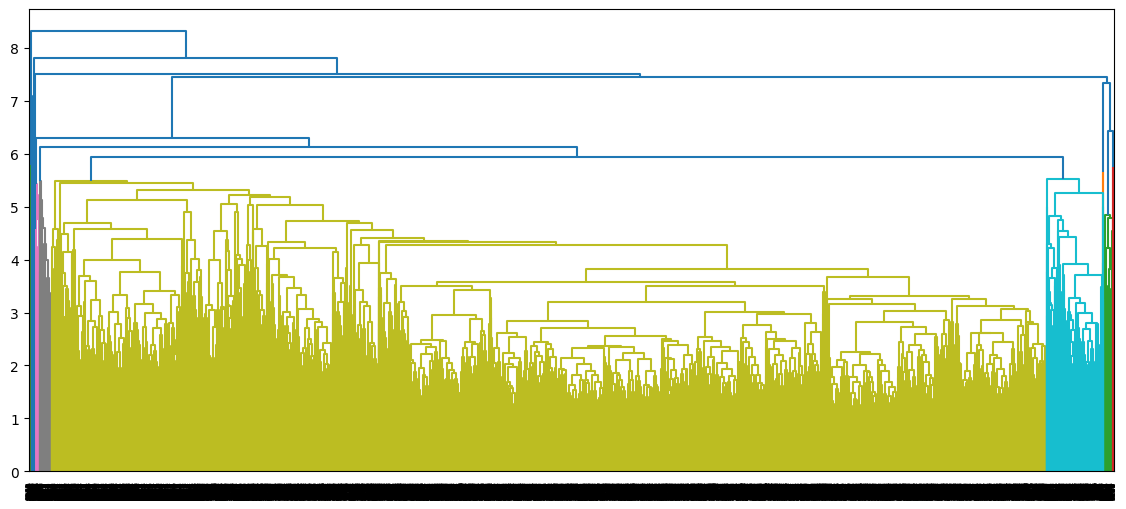

In [22]:
dendrogram(average_clustering)
plt.show()

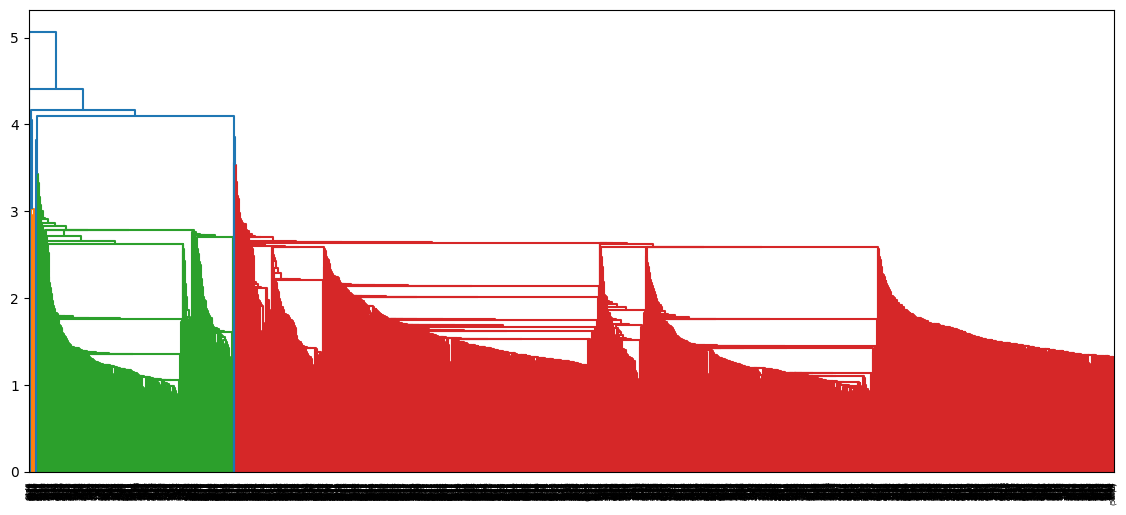

In [ ]:
#Tive que colocar essas configurações porque deu erro de recursividade
dendrogram(single_clustering, truncate_mode="level", p=500)
plt.show()

Das observações acima, a ligação média parece ser a que fornece o melhor agrupamento, em oposição à ligação única e completa, que respectivamente sugerem considerar um cluster e três clusters. Além disso, o número ótimo de clusters de dois corresponde ao nosso conhecimento prévio sobre o conjunto de dados, que são os dois tipos de tomadores. 

Agora que encontramos o número ideal de clusters, vamos ver o que esses clusters significam com base na pontuação de crédito do mutuário

<Axes: xlabel='Cluster', ylabel='fico'>

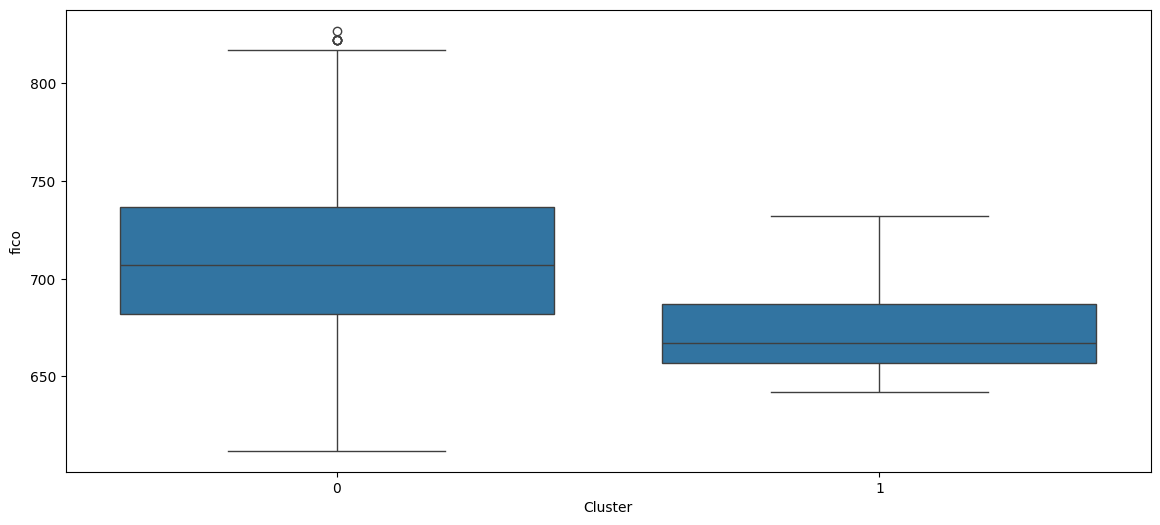

In [43]:
from scipy.cluster.hierarchy import cut_tree
cluster_labels = cut_tree(average_clustering, n_clusters=2).reshape(-1, )

data_without_outliers["Cluster"] = cluster_labels

sns.boxplot(x="Cluster", y="fico", data=data_without_outliers)

No boxplot acima, podemos observar que: 

- Os mutuários do cluster 0 têm as maiores pontuações de crédito.  

- Enquanto os tomadores do cluster 1 têm pontuações de crédito mais baixas.

### Apenas tentando entender os gráficos, não faz parte do tutorial original

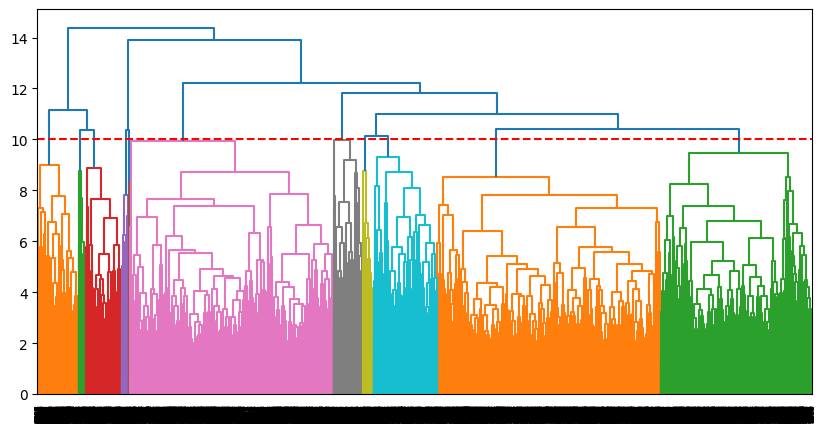

In [33]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 5))
dendrogram(complete_clustering)  # Pode testar também com average_clustering ou single_clustering
plt.axhline(y=10, color='r', linestyle='--')  # Ajuste o valor do corte conforme necessário
plt.show()

In [34]:
import numpy as np

# Obtendo as distâncias entre clusters
distances = complete_clustering[:, 2]  # Terceira coluna contém as distâncias de fusão
dist_diff = np.diff(distances[::-1])  # Diferença entre distâncias sucessivas (invertido para maior primeiro)

# Encontrando o ponto onde há maior salto (cotovelo)
best_cluster_idx = np.argmax(dist_diff) + 1  # O +1 compensa a diferença de índices
best_n_clusters = len(complete_clustering) - best_cluster_idx + 1  # Número de clusters

print(f"Número ideal de clusters: {best_n_clusters}")


Número ideal de clusters: 3655


In [35]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

best_score = -1
best_k = None

for k in range(2, 10):  # Testa de 2 a 10 clusters
    labels = fcluster(complete_clustering, k, criterion="maxclust")
    score = silhouette_score(scaled_data, labels)
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"Melhor número de clusters baseado na Silhueta: {best_k}")


Melhor número de clusters baseado na Silhueta: 2
